# A Walk Through Ensemble Models
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. Please check the pdf file for more details.*

In this exercise you will:

- get to know a useful package **pandas** for data analysis/preprocessing
- implement **decision tree** and apply it to a Titanic dataset
- implement a whole bunch of **ensemble methods**, including **random forest, and adaboost**, and apply them to a Titanic dataset

Please note that **YOU CANNOT USE ANY MACHINE LEARNING PACKAGE SUCH AS SKLEARN** for any homework, unless you are asked to.

In [1]:
# some basic imports
from scipy import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import re

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Let's first do some data preprocessing

Here we use [pandas](https://pandas.pydata.org/) to do data preprocessing. Pandas is a very popular and handy package for data science or machine learning. You can also refer to this official guide for pandas: [10 minutes to pandas](https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html)

In [2]:
# read titanic train and test data
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

print("train shape: {} test shape: {}".format(train.shape, test.shape))
# Showing overview of the train dataset
train.head(3)

train shape: (1047, 11) test shape: (262, 11)


,Pclass,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1,"Hays, Miss. Margaret Bechstein",female,24.0,0,0,11767,83.1583,C54,C
1,3,0,"Holm, Mr. John Fredrik Alexander",male,43.0,0,0,C 7075,6.4500,NaN,S
2,3,0,"Hansen, Mr. Claus Peter",male,41.0,2,0,350026,14.1083,NaN,S


## deal with missing values and transform to discrete variables

In [3]:
# copied from: https://www.kaggle.com/dmilla/introduction-to-decision-trees-titanic-dataset
full_data = [train, test]

# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

# Remove all NULLS in the Age column
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    # Next line has been improved to avoid warning
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [4]:
drop_elements = ['Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [5]:
train.head()

,Pclass,Survived,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,1,1,0,1,0,3,1,1,1,1,4
1,3,0,1,2,0,0,0,0,1,1,1
2,3,0,1,2,0,1,0,0,3,0,1
3,3,0,1,1,0,0,2,0,1,1,1
4,2,0,1,2,0,1,0,0,1,1,1


In [6]:
test.head()

,Pclass,Survived,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,3,0,1,0,0,0,2,0,1,1,1
1,3,0,1,2,2,2,0,0,4,0,2
2,3,0,1,0,2,3,0,0,8,0,2
3,2,0,1,2,0,1,0,0,1,1,1
4,3,0,1,1,0,1,0,0,1,1,1


One of the good thing of pd.DataFrame is that you can keep the column names along with the data, which can be beneficial for many case.

Another good thing is that pd.DataFrame can be converted to np.array implicitely.

Also, pd provides a lot of useful data manipulating methods for your convenience, though we may not use them in this homework.

In [7]:
X = train.drop(['Survived'], axis=1)
y = train["Survived"]
X_test = test.drop(['Survived'], axis=1)
y_test = test["Survived"]
print("train: {}, test: {}".format(X.shape, X_test.shape))

train: (1047, 10), test: (262, 10)


In [8]:
X

,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,1,0,1,0,3,1,1,1,1,4
1,3,1,2,0,0,0,0,1,1,1
2,3,1,2,0,1,0,0,3,0,1
3,3,1,1,0,0,2,0,1,1,1
4,2,1,2,0,1,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...
1042,2,0,0,1,3,0,1,4,0,4
1043,3,1,1,0,0,0,0,1,1,1
1044,1,1,2,0,3,1,1,1,1,1
1045,1,1,1,0,3,0,1,1,1,1


In [9]:
X.head()

,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,1,0,1,0,3,1,1,1,1,4
1,3,1,2,0,0,0,0,1,1,1
2,3,1,2,0,1,0,0,3,0,1
3,3,1,1,0,0,2,0,1,1,1
4,2,1,2,0,1,0,0,1,1,1


In [10]:
def accuracy(y_gt, y_pred):
    return np.sum(y_gt == y_pred) / y_gt.shape[0]

In [11]:
print("Survived: {:.4f}, Not Survivied: {:.4f}".format(y.sum() / len(y), 1 - y.sum() / len(y)))

Survived: 0.3878, Not Survivied: 0.6122


In [13]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
iris = load_iris()
cross_val_score(clf, iris.data, iris.target, cv=10)

array([1.        , 0.93333333, 1.        , 0.93333333, 0.93333333,
       0.86666667, 0.93333333, 1.        , 1.        , 1.        ])

[Text(167.4, 190.26, 'X[1] <= 0.5\ngini = 0.475\nsamples = 1047\nvalue = [641, 406]'),
 Text(83.7, 135.9, 'X[0] <= 2.5\ngini = 0.387\nsamples = 374\nvalue = [98, 276]'),
 Text(41.85, 81.53999999999999, 'X[4] <= 1.5\ngini = 0.122\nsamples = 199\nvalue = [13, 186]'),
 Text(20.925, 27.180000000000007, 'gini = 0.302\nsamples = 27\nvalue = [5, 22]'),
 Text(62.775000000000006, 27.180000000000007, 'gini = 0.089\nsamples = 172\nvalue = [8, 164]'),
 Text(125.55000000000001, 81.53999999999999, 'X[7] <= 4.5\ngini = 0.5\nsamples = 175\nvalue = [85, 90]'),
 Text(104.625, 27.180000000000007, 'gini = 0.487\nsamples = 150\nvalue = [63, 87]'),
 Text(146.475, 27.180000000000007, 'gini = 0.211\nsamples = 25\nvalue = [22, 3]'),
 Text(251.10000000000002, 135.9, 'X[6] <= 0.5\ngini = 0.312\nsamples = 673\nvalue = [543, 130]'),
 Text(209.25, 81.53999999999999, 'X[9] <= 1.5\ngini = 0.248\nsamples = 544\nvalue = [465, 79]'),
 Text(188.32500000000002, 27.180000000000007, 'gini = 0.227\nsamples = 491\nvalue = [42

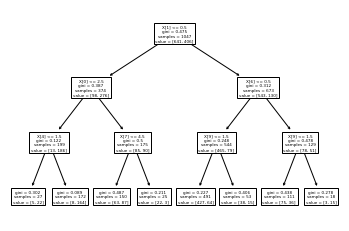

In [23]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X, y)
result = clf.score(X_test, y_test)
tree.plot_tree(clf)

In [15]:
print(result)

0.7938931297709924


## Decision Tree
Now it's your turn to do some real coding. Please implement the decision tree model in **decision_tree.py**. The PDF file provides some hints for this part.

Accuracy on train set: 0.7793696275071633
Accuracy on validation set: 0.767175572519084


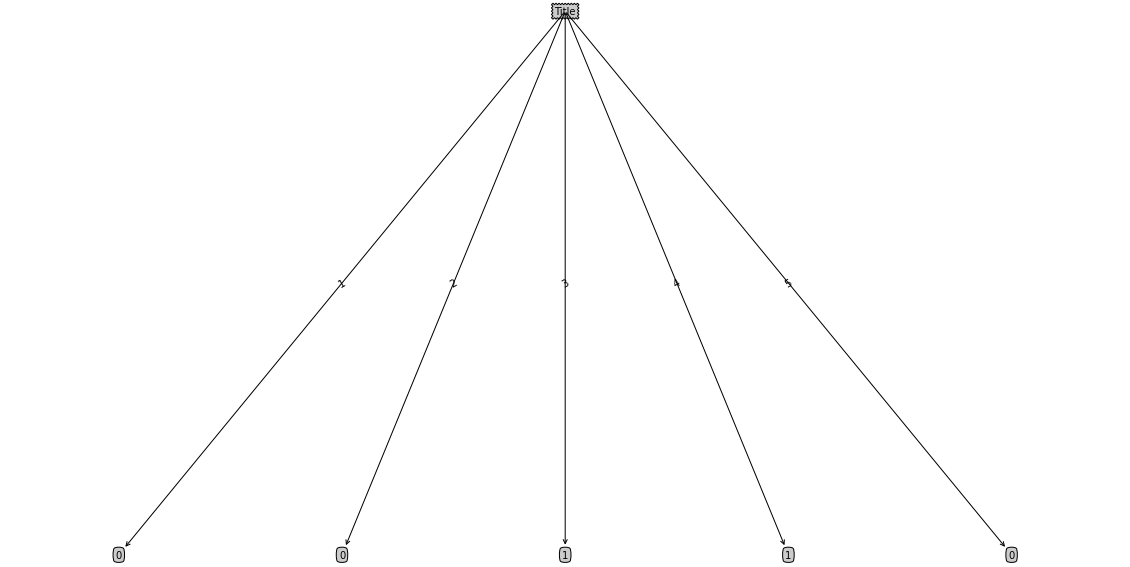

In [14]:
from decision_tree import DecisionTree

dt = DecisionTree(criterion='entropy', max_depth=2, min_samples_leaf=1, sample_feature=False)
dt.fit(X, y)

y_train_pred = dt.predict(X)

print("Accuracy on train set: {}".format(accuracy(y, y_train_pred)))

y_test_pred = dt.predict(X_test)

print("Accuracy on validation set: {}".format(accuracy(y_test, y_test_pred)))

# Plot the decision tree to get an intuition about how it makes decision
plt.figure(figsize=(20, 10))
dt.show()

In [95]:
# TODO: Train the best DecisionTree(best val accuracy) that you can. You should choose some 
# hyper-parameters such as critertion, max_depth, and min_samples_in_leaf 
# according to the cross-validation result.
# To reduce difficulty, you can use KFold here.
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=2020)

best_depth = -1
best_leaf = -1
best_criterion = 'entropy'
best_accuracy = 0

for train_indice, valid_indice in kf.split(X, y):
    X_train_fold, y_train_fold = X.loc[train_indice], y.loc[train_indice]
    X_val_fold, y_val_fold = X.loc[valid_indice], y.loc[valid_indice]
    print(X_train_fold.shape, X_val_fold.shape)
    
# begin answer
for depth in range(2, 6):
    for leaf in range(1, 10):
        for criterion in ['infogain_ratio', 'entropy', 'gini']:
            dt = DecisionTree(criterion=criterion, max_depth=depth, min_samples_leaf=leaf, sample_feature=False)
            y_val_pred = np.zeros(len(X))
            for train_indice, valid_indice in kf.split(X, y):
                X_train_fold, y_train_fold = X.loc[train_indice], y.loc[train_indice]
                X_val_fold, y_val_fold = X.loc[valid_indice], y.loc[valid_indice]
                dt.fit(X_train_fold, y_train_fold)
                y_val_pred[valid_indice] = dt.predict(X_val_fold)
            accu = accuracy(y, y_val_pred)
            print(criterion, 'depth:', depth, 'leaf', leaf, 'accu:', accu)
            if accu > best_accuracy:
                best_criterion = criterion
                best_depth = depth
                best_leaf = leaf
                best_accuracy = accu
print('best parameters:')
print('criterion:', best_criterion, 'best_depth:', best_depth, 'best_leaf:', best_leaf, 'best_accu:', best_accuracy)

# end answer

(837, 10) (210, 10)
(837, 10) (210, 10)
(838, 10) (209, 10)
(838, 10) (209, 10)
(838, 10) (209, 10)
infogain_ratio depth: 2 leaf 1 accu: 0.7707736389684814
entropy depth: 2 leaf 1 accu: 0.7707736389684814
gini depth: 2 leaf 1 accu: 0.7707736389684814
infogain_ratio depth: 2 leaf 2 accu: 0.7707736389684814
entropy depth: 2 leaf 2 accu: 0.7707736389684814
gini depth: 2 leaf 2 accu: 0.7707736389684814
infogain_ratio depth: 2 leaf 3 accu: 0.7707736389684814
entropy depth: 2 leaf 3 accu: 0.7707736389684814
gini depth: 2 leaf 3 accu: 0.7707736389684814
infogain_ratio depth: 2 leaf 4 accu: 0.7707736389684814
entropy depth: 2 leaf 4 accu: 0.7707736389684814
gini depth: 2 leaf 4 accu: 0.7707736389684814
infogain_ratio depth: 2 leaf 5 accu: 0.7707736389684814
entropy depth: 2 leaf 5 accu: 0.7707736389684814
gini depth: 2 leaf 5 accu: 0.7707736389684814
infogain_ratio depth: 2 leaf 6 accu: 0.7707736389684814
entropy depth: 2 leaf 6 accu: 0.7707736389684814
gini depth: 2 leaf 6 accu: 0.77077363896

In [19]:
# report the accuracy on test set
# begin answer
# end answer
dt.fit(X, y)
print("Accuracy on train set: {}".format(accuracy(y, dt.predict(X))))
print("Accuracy on test set: {}".format(accuracy(y_test, dt.predict(X_test))))

Accuracy on train set: 0.7793696275071633
Accuracy on test set: 0.767175572519084


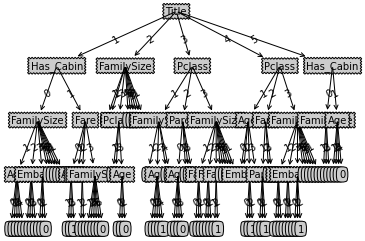

In [19]:
dt = DecisionTree(criterion='infogain_ratio', max_depth=5, min_samples_leaf=9, sample_feature=False)
dt.fit(X, y)
dt.show()

## Random Forest
Please implement the random forest model in **random_forest.py**. The PDF file provides some hints for this part.

In [22]:
from random_forest import RandomForest

base_learner = DecisionTree(criterion='entropy', max_depth=2, min_samples_leaf=1, sample_feature=True)
rf = RandomForest(base_learner=base_learner, n_estimator=10, seed=2020)
rf.fit(X, y)

y_train_pred = rf.predict(X)

print("Accuracy on train set: {}".format(accuracy(y, y_train_pred)))

Accuracy on train set: 0.6189111747851003


In [104]:
# TODO: Train the best RandomForest that you can. You should choose some 
# hyper-parameters such as max_depth, and min_samples_in_leaf 
# according to the cross-validation result.
# begin answer

best_depth = -1
best_leaf = -1
best_criterion = 'entropy'
best_accuracy = 0

kf_rf = KFold(n_splits=5, shuffle=True, random_state=2020)

for num in [10, 100]:
    for depth in range(3, 6):
        for leaf in range(1, 5):
            for criterion in ['infogain_ratio', 'entropy', 'gini']:
                base_learner = DecisionTree(criterion=criterion, max_depth=depth, min_samples_leaf=leaf, sample_feature=False)
                rf = RandomForest(base_learner=base_learner, n_estimator=num, seed=2020)
                y_val_pred = np.zeros(len(X))
                for train_indice, valid_indice in kf_rf.split(X, y):
                    X_train_fold, y_train_fold = X.loc[train_indice], y.loc[train_indice]
                    X_val_fold, y_val_fold = X.loc[valid_indice], y.loc[valid_indice]
                    rf.fit(X_train_fold, y_train_fold)
                    y_val_pred[valid_indice] = rf.predict(X_val_fold)
                accu = accuracy(y, y_val_pred)
                print('n_estimator:', num, '| criterion:', criterion, '| depth:', depth, '| leaf', leaf, '| accu:', accu)
                if accu > best_accuracy:
                    best_criterion = criterion
                    best_depth = depth                                                                                                                                                       best_leaf = leaf
                    best_accuracy = accu
print('best parameters:')
print('criterion:', best_criterion, 'best_depth:', best_depth, 'best_leaf:', best_leaf, 'best_accu:', best_accuracy)
# end answer

n_estimator: 10 | criterion: infogain_ratio | depth: 3 | leaf 1 | accu: 0.792741165234002
n_estimator: 10 | criterion: entropy | depth: 3 | leaf 1 | accu: 0.792741165234002
n_estimator: 10 | criterion: gini | depth: 3 | leaf 1 | accu: 0.792741165234002
n_estimator: 10 | criterion: infogain_ratio | depth: 3 | leaf 2 | accu: 0.792741165234002
n_estimator: 10 | criterion: entropy | depth: 3 | leaf 2 | accu: 0.792741165234002
n_estimator: 10 | criterion: gini | depth: 3 | leaf 2 | accu: 0.792741165234002
n_estimator: 10 | criterion: infogain_ratio | depth: 3 | leaf 3 | accu: 0.792741165234002
n_estimator: 10 | criterion: entropy | depth: 3 | leaf 3 | accu: 0.792741165234002
n_estimator: 10 | criterion: gini | depth: 3 | leaf 3 | accu: 0.792741165234002
n_estimator: 10 | criterion: infogain_ratio | depth: 3 | leaf 4 | accu: 0.792741165234002
n_estimator: 10 | criterion: entropy | depth: 3 | leaf 4 | accu: 0.792741165234002
n_estimator: 10 | criterion: gini | depth: 3 | leaf 4 | accu: 0.7927

## n_estimators = 10

In [18]:
# report the accuracy on test set
# begin answer
# end answer

base_learner = DecisionTree(criterion='infogain_ratio', max_depth=4, min_samples_leaf=1, sample_feature=False)
rf = RandomForest(base_learner=base_learner, n_estimator=10, seed=2020)
rf.fit(X, y)
print("Accuracy on train set: {}".format(accuracy(y, rf.predict(X))))
print("Accuracy on test set: {}".format(accuracy(y_test, rf.predict(X_test))))

Accuracy on train set: 0.8261700095510984
Accuracy on test set: 0.8053435114503816


## n_estimators = 100

In [106]:
# report the accuracy on test set
# begin answer
# end answer

base_learner = DecisionTree(criterion=best_criterion, max_depth=best_depth, min_samples_leaf=best_leaf, sample_feature=False)
rf = RandomForest(base_learner=base_learner, n_estimator=100, seed=2020)
rf.fit(X, y)
print("Accuracy on train set: {}".format(accuracy(y, rf.predict(X))))
print("Accuracy on test set: {}".format(accuracy(y_test, rf.predict(X_test))))

Accuracy on train set: 0.828080229226361
Accuracy on test set: 0.8091603053435115


In [23]:
from sklearn import ensemble 

In [30]:
print(X.shape, y.shape)
rf = ensemble.RandomForestClassifier(n_estimators=100, max_depth=4, criterion='gini')
rf.fit(X, y)
print("Accuracy on train set: {}".format(accuracy(y, rf.predict(X))))
print("Accuracy on test set: {}".format(accuracy(y_test, rf.predict(X_test))))

(1047, 10) (1047,)
Accuracy on train set: 0.8166189111747851
Accuracy on test set: 0.8053435114503816


## Adaboost
Please implement the adaboost model in **adaboost.py**. The PDF file provides some hints for this part.

## n_estimators = 10

In [37]:
from adaboost import Adaboost

base_learner = DecisionTree(criterion='entropy', max_depth=2, min_samples_leaf=1, sample_feature=False)
ada = Adaboost(base_learner=base_learner, n_estimator=50, seed=2020)
ada.fit(X, y)

y_train_pred = ada.predict(X)

y_test_pred = ada.predict(X_test)

print("Accuracy on train set: {}".format(accuracy(y, y_train_pred)))
print("Accuracy on validation set: {}".format(accuracy(y_test, y_test_pred)))

Accuracy on train set: 0.7793696275071633
Accuracy on validation set: 0.767175572519084


## n_estimators = 100

In [36]:
from adaboost import Adaboost

base_learner = DecisionTree(criterion='entropy', max_depth=2, min_samples_leaf=1, sample_feature=False)
ada = Adaboost(base_learner=base_learner, n_estimator=100, seed=2020)
ada.fit(X, y)

y_train_pred = ada.predict(X)

y_test_pred = ada.predict(X_test)

print("Accuracy on train set: {}".format(accuracy(y, y_train_pred)))
print("Accuracy on validation set: {}".format(accuracy(y_test, y_test_pred)))

Accuracy on train set: 0.7793696275071633
Accuracy on validation set: 0.767175572519084


In [ ]:
# TODO: Train the best Adaboost that you can. You should choose some 
# hyper-parameters such as max_depth, and min_samples_in_leaf 
# according to the cross-validation result.
# begin answer
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=2020)
criters = ['infogain_ratio', 'entropy', 'gini']
estimators = [10, 100]
best_criter = criters[0]
best_estimator = estimators[0]
best_depth = 3
best_leaves = 2
best_accuracy = 0.0

for n_estimator in estimators:
    temp_accuracy = 0.0
    for depth in range(2, 5):
        for leaves in range(1, 4):
            for criter in criters:
                base_learner = DecisionTree(criterion=criter, max_depth=depth, min_samples_leaf=leaves, sample_feature=False)
                ada = Adaboost(base_learner=base_learner, n_estimator=n_estimator, seed=2020)
                predict = np.zeros(len(X))
                for train_indice, valid_indice in kf.split(X, y):
                    X_train_fold, y_train_fold = X.loc[train_indice], y.loc[train_indice]
                    X_val_fold, y_val_fold = X.loc[valid_indice], y.loc[valid_indice]
                    ada.fit(X_train_fold, y_train_fold)
                    predict[valid_indice] = ada.predict(X_val_fold)
                accuracy_now = accuracy(y, predict)
                if accuracy_now > temp_accuracy:
                    temp_criter = criter
                    temp_estimator = n_estimator
                    temp_depth = depth
                    temp_leaves = leaves
                    temp_accuracy = accuracy_now
        print(temp_accuracy)
    print("temp_estimator: {}, temp_criter: {}, temp_depth: {}, temp_leaves: {}".format(temp_estimator, temp_criter, temp_depth, temp_leaves))
    print("Training error rate: {}".format(accuracy(y, ada.predict(X))))
    print("Validation error rate: {}".format(temp_accuracy))
    if(temp_accuracy > best_accuracy):
        best_criter = temp_criter
        best_estimator = temp_estimator
        best_depth = temp_depth
        best_leaves = temp_leaves
        best_accuracy = temp_accuracy

print("best_estimator: {}, best_criter: {}, best_depth: {}, best_leaves: {}".format(best_estimator, best_criter, best_depth, best_leaves))
# end answer

In [38]:
# report the accuracy on test set
# begin answer
base_learner = DecisionTree(criterion = 'gini', max_depth = 3, min_samples_leaf = 1, sample_feature = False)
ada = Adaboost(base_learner = base_learner, n_estimator = 10, seed = 2020)
# end answer
ada.fit(X, y)
print("Accuracy on train set: {}".format(accuracy(y, ada.predict(X))))
print("Accuracy on test set: {}".format(accuracy(y_test, ada.predict(X_test))))

Accuracy on train set: 0.8013371537726839
Accuracy on test set: 0.8129770992366412
